In [1]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LinearSegmentedColormap
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import spearmanr
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import silhouette_samples, silhouette_score
from kneed import KneeLocator

DATA_DIR = 'data'

**Research question:**

## Task 1: Data Preprocessing

In [2]:
# Load the data
activity = pd.read_csv(f'{DATA_DIR}/activity.csv')
activity_sizes = {'Original': len(activity)}

# Cast timestamps to datetime
activity['activity_started'] = pd.to_datetime(activity['activity_started'], unit='s')
activity['activity_completed'] = pd.to_datetime(activity['activity_completed'], unit='s')
activity['activity_updated'] = pd.to_datetime(activity['activity_updated'], unit='s')

# Remove entries where the activity_completed was before the activity_started
activity = activity[activity['activity_completed'] > activity['activity_started']]
activity_sizes['After removing missing or inconcistent completion'] = len(activity)

# Create a column with the duration of the activity
activity['activity_duration'] = activity['activity_completed'] - activity['activity_started']
activity['activity_duration_minutes'] = activity['activity_duration'].dt.total_seconds() / 60

# Remove entries where the activity_completed is more than 24 hours after the activity_started
activity = activity[activity['activity_duration_minutes'] <= 24 * 60]
activity_sizes['After removing duration > 24h'] = len(activity)

# Compute IQR bounds for filtering
Q1 = activity['activity_duration_minutes'].quantile(0.25)
Q3 = activity['activity_duration_minutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
# Filter outliers
activity = activity[
    (activity['activity_duration_minutes'] >= lower_bound) &
    (activity['activity_duration_minutes'] <= upper_bound)
]

# Dataset evolution
print("Data set sizes at each stage:")
for stage, size in activity_sizes.items():
    print(f"- {stage}: {size} entries ({size / activity_sizes['Original'] * 100:.2f}%)")

user_daily_activity = activity.copy(deep=True)

# Create new column for activity started day
user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)

# Drop duplicates in user_id, active_day
user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')

# Compute gaps between active days for each user
user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

# Keep only relevnt columns
columns = ['user_id', 'active_day', 'gap_days']
user_daily_activity = user_daily_activity[columns]

# Compute the median of gap_days per user
user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)

# Add the number of active days of that user (count)
user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

# Add the median activity duration of that user (activity_completed - activity_started) only when activity_completed is not missing
user_activity['median_activity_duration'] = activity.groupby('user_id').apply(
    lambda x: (x['activity_completed'] - x['activity_started']).median()
).reset_index(drop=True)

# Add the number of activities of that user (count)
user_activity['activities_count'] = activity.groupby('user_id')['activity_id'].count().values
# Add the number of unique activity types of that user
user_activity['activity_types_count'] = activity.groupby('user_id')['activity_type'].nunique().values

# Convert timedelta to minutes
user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60

# Drop the original timedelta column
user_activity.drop(columns=['median_activity_duration'], inplace=True)

print("Activity per User:")
display(user_activity.head())
print("Shape:", user_activity.shape)



Data set sizes at each stage:
- Original: 72897 entries (100.00%)
- After removing missing or inconcistent completion: 38881 entries (53.34%)
- After removing duration > 24h: 26217 entries (35.96%)
Activity per User:


/var/folders/q0/bnk2bs5j0lj3ph23b8l_1p100000gn/T/ipykernel_21373/2398963956.py:64: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  user_activity['median_activity_duration'] = activity.groupby('user_id').apply(


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes
0,1,4.0,11,19,2,4.716667
1,4,7.5,7,31,1,2.266667
2,6,7.0,9,30,2,7.658333
3,7,4.0,16,30,2,13.583333
4,9,12.0,8,26,2,6.466667


Shape: (843, 6)


New preprocessing starts here

In [3]:
# TODO: Monter ceci avant la creation de user_activity

# Remove outliers in activity_started with IQR method
print("Length before removing outliers in activity_started:", activity.shape[0])
Q1 = activity['activity_started'].quantile(0.25)
Q3 = activity['activity_started'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
activity = activity[
    (activity['activity_started'] >= lower_bound) &
    (activity['activity_started'] <= upper_bound)
]
print("Length after removing outliers in activity_started:", activity.shape[0])

Length before removing outliers in activity_started: 22754
Length after removing outliers in activity_started: 21803


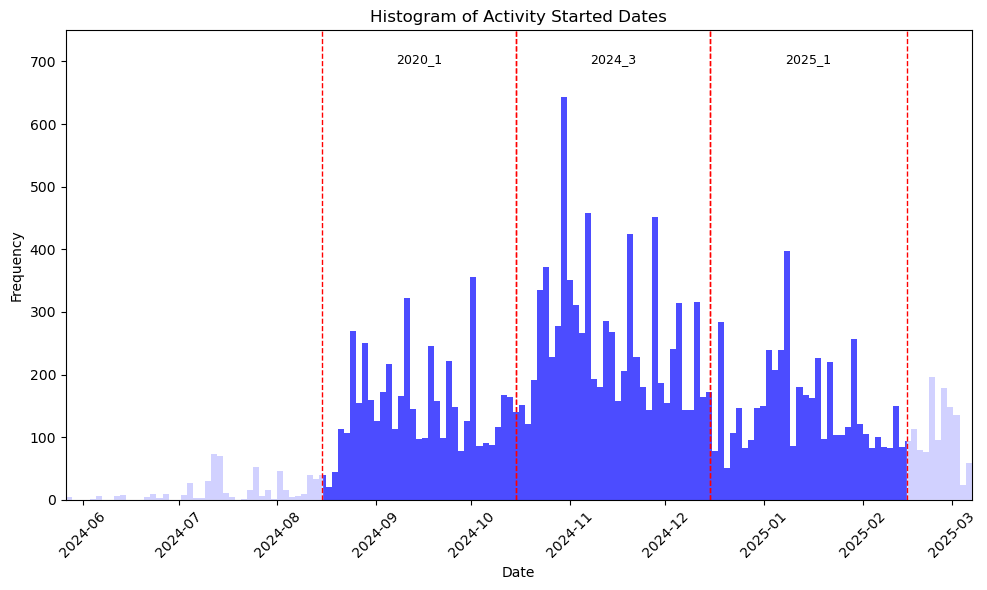

In [4]:
# Define your dynamic periods
periods = [
    ('2024-08-15', '2024-10-15', '2020_1'),
    ('2024-10-15', '2024-12-15', '2024_3'),
    ('2024-12-15', '2025-02-15', '2025_1'),
    # ('2025-02-15', '2025-04-15', '2025_2'),
    # Add more periods here without modifying any code below
]

# Prepare histogram data
min_date = activity['activity_started'].min()
max_date = activity['activity_started'].max()

# Plot histogram with explicit range starting from min_date
plt.figure(figsize=(10, 6))
counts, bins, patches = plt.hist(activity['activity_started'], bins=150, color='blue', alpha=0.7, range=(min_date, max_date))

# Slightly shorten bars to leave space for text labels
for patch in patches:
    patch.set_height(patch.get_height() * 0.9)

# Convert period boundaries to timestamps
period_bounds = [(pd.Timestamp(start), pd.Timestamp(end)) for start, end, _ in periods]
first_start = period_bounds[0][0]
last_end = period_bounds[-1][1]

# Shade before first and after last period
color, alpha = 'white', 0.75
if min_date < first_start:
    plt.axvspan(min_date, first_start, color=color, alpha=alpha)
if max_date > last_end:
    plt.axvspan(last_end, max_date, color=color, alpha=alpha)

# Add vertical dashed lines and period labels
for (start_ts, end_ts), (_, _, period_name) in zip(period_bounds, periods):
    midpoint = start_ts + (end_ts - start_ts) / 2
    plt.axvline(start_ts, color='red', linestyle='--', linewidth=1)
    plt.axvline(end_ts, color='red', linestyle='--', linewidth=1)

    # Add period name slightly above shortened bars
    plt.text(midpoint, max(counts), period_name,
             ha='center', va='top', fontsize=9, color='black',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Histogram of Activity Started Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.xlim(min_date, max_date)
plt.tight_layout()
plt.show()



In [5]:
def create_user_activity_by_period(activity_df, periods):
    """
    Creates user activity dataframes separated by time periods.

    Parameters:
    -----------
    activity_df : pandas DataFrame
        The original activity dataframe.
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods.

    Returns:
    --------
    dict
        Dictionary of user_activity dataframes for each period.
    """
    user_activity_periods = {}

    for start_date, end_date, period_name in periods:
        period_activity = activity_df[
            (activity_df['activity_started'] >= pd.Timestamp(start_date)) &
            (activity_df['activity_started'] < pd.Timestamp(end_date))
        ].copy(deep=True)

        if period_activity.empty:
            continue

        user_daily_activity = period_activity.copy()
        user_daily_activity['active_day'] = pd.to_datetime(user_daily_activity['activity_started'].dt.date)
        user_daily_activity.drop_duplicates(subset=['user_id', 'active_day'], inplace=True, keep='first')
        user_daily_activity.sort_values(['user_id', 'active_day'], inplace=True)
        user_daily_activity['previous_day'] = user_daily_activity.groupby('user_id')['active_day'].shift(1)
        user_daily_activity['gap_days'] = (user_daily_activity['active_day'] - user_daily_activity['previous_day']).dt.days

        user_daily_activity = user_daily_activity[['user_id', 'active_day', 'gap_days']]

        user_activity = user_daily_activity.groupby('user_id')['gap_days'].median().reset_index()
        user_activity.rename(columns={'gap_days': 'median_gap_days'}, inplace=True)
        user_activity['active_days_count'] = user_daily_activity.groupby('user_id')['active_day'].count().values

        duration_median = (period_activity['activity_completed'] - period_activity['activity_started']).groupby(period_activity['user_id']).median()

        user_activity['median_activity_duration'] = duration_median.reset_index(drop=True)

        user_activity['activities_count'] = period_activity.groupby('user_id')['activity_id'].count().values
        user_activity['activity_types_count'] = period_activity.groupby('user_id')['activity_type'].nunique().values

        user_activity['median_activity_duration_minutes'] = user_activity['median_activity_duration'].dt.total_seconds() / 60
        user_activity.drop(columns=['median_activity_duration'], inplace=True)
        user_activity['period'] = period_name

        user_activity_periods[period_name] = user_activity

    return user_activity_periods

# Create the period user activity dict
user_activity_periods = create_user_activity_by_period(activity, periods)

# Concatenate all into one dataframe dynamically
all_periods_user_activity = pd.concat(user_activity_periods.values(), ignore_index=True)
print("\nUser activity across all periods:")
display(all_periods_user_activity.head())
print(f"Shape: {all_periods_user_activity.shape}")
print("\n")

# Number of unique users in each period
for period_name, user_activity_df in user_activity_periods.items():
    unique_users = user_activity_df['user_id'].nunique()
    print(f"Unique users in {period_name}: {unique_users}")
print("\n")

# Continous periods pairs
period_pairs = []
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    period_pairs.append((period1, period2))
    
# Number of unique users in pairs of periods
for period1, period2 in period_pairs:
    users_period1 = user_activity_periods[period1]['user_id'].unique()
    users_period2 = user_activity_periods[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period
0,128,NaN,1,6,2,1.525000,2020_1
1,129,NaN,1,1,1,1.850000,2020_1
2,130,NaN,1,66,4,0.375000,2020_1
3,131,NaN,1,11,2,0.600000,2020_1
4,142,NaN,1,9,2,6.483333,2020_1


Shape: (1409, 7)


Unique users in 2020_1: 427
Unique users in 2024_3: 565
Unique users in 2025_1: 417


Common users between 2020_1 and 2024_3: 314
Common users between 2024_3 and 2025_1: 310


In [6]:
# Load the data
all_scores = pd.read_csv(f'{DATA_DIR}/all_scores.csv')

# Cast timestamps to datetime
all_scores['time'] = pd.to_datetime(all_scores['time'], unit='s')

In [ ]:
def compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods):
    """
    Computes median scores per user for each period and merges with corresponding user_activity.
    
    Parameters:
    -----------
    all_scores : pandas DataFrame
        DataFrame containing all user scores
    user_activity_periods : dict
        Dictionary of user_activity dataframes for each period
    periods : list of tuples
        List of (start_date, end_date, period_name) tuples defining the periods
    
    Returns:
    --------
    dict
        Dictionary of merged student dataframes for each period
    """
    students_by_period = {}
    
    for start_date, end_date, period_name in periods:        
        period_scores = all_scores[
            (all_scores['time'] >= pd.Timestamp(start_date)) & 
            (all_scores['time'] < pd.Timestamp(end_date))
        ].copy()

        if period_scores.empty:
            continue
        
        user_activity = user_activity_periods.get(period_name)
        if user_activity is None or user_activity.empty:
            continue

        students_median_score = period_scores.groupby('user_id')['percentage'].median().reset_index()
        students_median_score.rename(columns={'percentage': 'median_score'}, inplace=True)
        students_median_score['scores_count'] = period_scores.groupby('user_id')['percentage'].count().values

        # Filter out users with only one score
        students_median_score_filtered = students_median_score[students_median_score['scores_count'] > 1]
        # print(f"Users with at least 2 scores in {period_name}: {len(students_median_score_filtered)}")

        # IQR-based outlier removal
        Q1 = students_median_score_filtered['scores_count'].quantile(0.25)
        Q3 = students_median_score_filtered['scores_count'].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        length_before = len(students_median_score_filtered)
        students_median_score_filtered = students_median_score_filtered[
            (students_median_score_filtered['scores_count'] >= lower_bound) & 
            (students_median_score_filtered['scores_count'] <= upper_bound)
        ]
        length_after = len(students_median_score_filtered)

        # print(f"Number of users before outlier removal: {length_before}")
        # print(f"Number of users after outlier removal: {length_after} ({length_after / length_before * 100:.2f}%)")

        # Filter period_scores to retain users only
        period_scores_filtered = period_scores[period_scores['user_id'].isin(students_median_score_filtered['user_id'])]

        students = user_activity.merge(
            students_median_score_filtered,
            how='inner',
            on='user_id'
        )
        students['period'] = period_name

        # print(f"Number of users in user_activity: {user_activity['user_id'].nunique()}")
        # print(f"Number of users in filtered scores: {students_median_score_filtered['user_id'].nunique()}")
        # print(f"Number of users after merge: {students['user_id'].nunique()}")
        
        students_by_period[period_name] = students

    return students_by_period

# Compute and merge scores
students_by_period = compute_and_merge_median_scores_by_period(all_scores, user_activity_periods, periods)

# Combine all periods into one dataframe
all_students = pd.concat(students_by_period.values(), ignore_index=True)
print("\nUser activity and scores across all periods:")
display(all_students.head())
print(f"Shape: {all_students.shape}")
print("\n")

# Analyze user counts per period
for period_name, df in students_by_period.items():
    print(f"Period {period_name}: {df['user_id'].nunique()} unique users")
print("\n")

# Analyze overlap across periods
if len(students_by_period) > 1:
    user_period_counts = all_students.groupby('user_id')['period'].nunique()
    for i in range(1, len(periods) + 1):
        users_in_n_periods = user_period_counts[user_period_counts == i].count()
        print(f"Users appearing in exactly {i} periods: {users_in_n_periods}")
print("\n")

# Number of unique users in pairs of periods
for i in range(len(periods) - 1):
    period1 = periods[i][2]
    period2 = periods[i + 1][2]
    users_period1 = students_by_period[period1]['user_id'].unique()
    users_period2 = students_by_period[period2]['user_id'].unique()
    common_users = len(set(users_period1) & set(users_period2))
    print(f"Common users between {period1} and {period2}: {common_users}")


User activity and scores across all periods:


,user_id,median_gap_days,active_days_count,activities_count,activity_types_count,median_activity_duration_minutes,period,median_score,scores_count
0,433,8.5,3,20,3,2.208333,2020_1,75.000,3
1,436,5.5,5,25,3,5.050000,2020_1,70.140,2
2,465,3.5,5,34,3,1.866667,2020_1,95.000,2
3,475,3.0,6,15,2,12.766667,2020_1,88.750,2
4,3112,7.0,4,6,2,1.850000,2020_1,33.335,2


Shape: (641, 9)


Period 2020_1: 119 unique users
Period 2024_3: 329 unique users
Period 2025_1: 193 unique users


Users appearing in exactly 1 periods: 219
Users appearing in exactly 2 periods: 130
Users appearing in exactly 3 periods: 54


Common users between 2020_1 and 2024_3: 93
Common users between 2024_3 and 2025_1: 141


## Task 2: Model Building

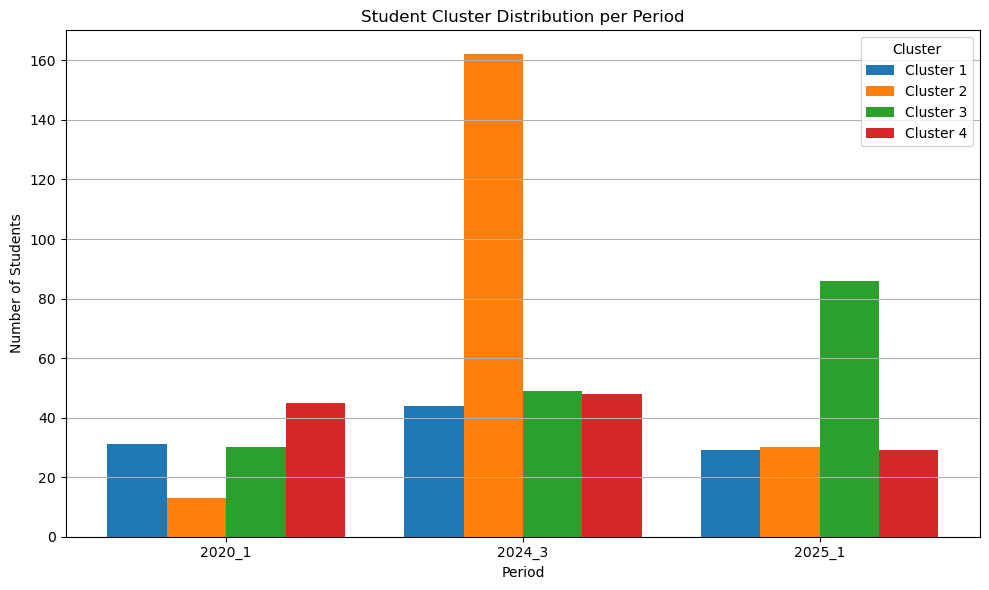

In [9]:
def cluster_students_by_period(students_by_period, k=4):
    """
    Applies KMeans clustering to students from each period and returns one grouped bar plot of cluster distribution.

    Parameters:
    -----------
    students_by_period : dict
        Dictionary of student dataframes for each period
    k : int, default=4
        Number of clusters to use

    Returns:
    --------
    dict
        Dictionary of clustered student dataframes per period
    """
    from collections import defaultdict

    columns_used = [
        'median_gap_days',
        'active_days_count',
        'activities_count',
        'activity_types_count',
        'median_activity_duration_minutes'
    ]
    
    clustered_students = {}
    cluster_distributions = defaultdict(lambda: [0]*k)  # period_name -> list of counts for each cluster (0...k-1)

    for period_name, df in students_by_period.items():
        if df is None or df.empty:
            continue
        
        df_clean = df.dropna(subset=columns_used)
        if len(df_clean) < k:
            continue
        
        X = df_clean[columns_used]
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)

        df_clean = df_clean.copy()
        df_clean['cluster'] = labels

        # Count cluster assignments
        counts = df_clean['cluster'].value_counts().sort_index()
        for cluster_idx in range(k):
            cluster_distributions[period_name][cluster_idx] = counts.get(cluster_idx, 0)

        # Store clustered data
        clustered_students[period_name] = df_clean

    # Plot one grouped bar chart
    if clustered_students:
        periods_sorted = sorted(cluster_distributions.keys())
        x = np.arange(len(periods_sorted))
        width = 0.2  # width of each bar

        plt.figure(figsize=(10, 6))
        for i in range(k):
            counts = [cluster_distributions[period][i] for period in periods_sorted]
            plt.bar(x + i * width, counts, width, label=f'Cluster {i+1}')

        plt.xlabel('Period')
        plt.ylabel('Number of Students')
        plt.title('Student Cluster Distribution per Period')
        plt.xticks(x + width * (k-1)/2, periods_sorted)
        plt.legend(title='Cluster')
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

    return clustered_students

clustered_students_by_period = cluster_students_by_period(students_by_period, k=4)

In [27]:
import plotly.graph_objects as go

def plot_cluster_transition_sankey(clustered_students_by_period):
    """
    Plot a Sankey diagram showing student transitions between clusters across periods.
    
    Parameters:
    -----------
    clustered_students_by_period : dict
        Dictionary where keys are period names and values are DataFrames with 'user_id' and 'cluster' columns.
    """
    # Step 1: Sort periods chronologically
    sorted_periods = sorted(clustered_students_by_period.keys())
    
    # Step 2: Build a long-format DataFrame: rows = (user_id, period, cluster)
    records = []
    for period in sorted_periods:
        df = clustered_students_by_period[period]
        for _, row in df[['user_id', 'cluster']].dropna().iterrows():
            records.append((row['user_id'], period, int(row['cluster'])))
    
    transition_df = pd.DataFrame(records, columns=['user_id', 'period', 'cluster'])
    
    # Step 3: Pivot table where each row is a user and each column is their cluster in a given period
    pivot = transition_df.pivot(index='user_id', columns='period', values='cluster')

    # Step 4: Build source–target–value for each pair of adjacent periods
    label_list = []
    label_index = {}
    source = []
    target = []
    value = []

    for i in range(len(sorted_periods) - 1):
        p1, p2 = sorted_periods[i], sorted_periods[i + 1]

        transitions = pivot[[p1, p2]].dropna()
        transitions = transitions.astype(int)

        for (c1, c2), count in transitions.groupby([p1, p2]).size().items():
            label1 = f"{p1}_C{c1}"
            label2 = f"{p2}_C{c2}"

            for label in (label1, label2):
                if label not in label_index:
                    label_index[label] = len(label_list)
                    label_list.append(label)

            source.append(label_index[label1])
            target.append(label_index[label2])
            value.append(count)

    # Step 5: Plot using Plotly
    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color="black", width=0.5),
            label=label_list
        ),
        link=dict(
            source=source,
            target=target,
            value=value
        )
    )])

    fig.update_layout(title_text="Student Cluster Transitions Across Periods", font_size=12)
    fig.show()

plot_cluster_transition_sankey(clustered_students_by_period)
